In [1]:
%matplotlib inline
import numpy as np
from numpy import sqrt
import scipy.constants
import matplotlib.pyplot as plt
import scipy.special
import os

m_e=scipy.constants.m_e
m_p=scipy.constants.m_p
e=scipy.constants.e
c=scipy.constants.c

def S_k_omega(lambda_range, lambda_in, theta, A, T_e,T_i,n_e,Z, v_fi=0, v_fe=0):
    '''
    Returns a normalised spectral density function.
    Implements the model of Sheffield (2nd Ed.)
    One ion, one electron species with independent temeperatures
    Electron velocity is with respect to ion velocity
    Returns S(k,w) for each wavelength in lambda_range assuming
    input wavelength lambda_in. Both in metres
    Theta is angle between k_in and k_s in degrees
    A i atomic mass, Z is ion charge
    T_e, T_i in eV, n_e in cm^-3
    V_fi and V_fe in m/s
    '''
    #physical parameters
    pi=np.pi
    m_i=m_p*A
    om_pe=5.64e4*n_e**0.5#electron plasma frequency
    #define omega and k as in Sheffield 113
    ki=2*pi/lambda_in
    omega_i=((c*ki)**2+om_pe**2)**0.5

    ks=2*pi/lambda_range
    omega_s=((c*ks)**2+om_pe**2)**0.5
    
    th=theta/180.0*np.pi#convert to radians for cosine function
    k=(ks**2+ki**2-2*ks*ki*np.cos(th))**0.5
    omega=omega_s-omega_i
    
    #define dimensionless parameters ala Sheffield
    a=sqrt(2*e*T_e/m_e)
    b=sqrt(2*e*T_i/m_i)
    x_e=(omega/k+v_fe+v_fi)/a
    x_i=(omega/k+v_fi)/b
    lambda_De=7.43*(T_e/n_e)**0.5 #Debeye length in m
    #the all important alpha parameter
    alpha=1/(k*lambda_De)
    #set up the Fadeeva function
    w=scipy.special.wofz
    chi_i=alpha**2*Z*T_e/T_i*(1+1j*sqrt(pi)*x_i*w(x_i)) #ion susceptibility
    chi_e=alpha**2*(1+1j*sqrt(pi)*x_e*w(x_e))#electron susceptibility
    epsilon=1+chi_e+chi_i#dielectric function
    fe0=1/(sqrt(pi)*a)*np.exp(-x_e**2)#electron Maxwellian function
    fi0=1/(sqrt(pi)*b)*np.exp(-x_i**2)#ion Maxwellian
    Skw=2*pi/k*abs(1-chi_e/epsilon)**2*fe0+Z*abs(chi_e/epsilon)**2*fi0
    return k, Skw/Skw.max() #normalise the spectrum

In [5]:
def S_k_omega_nu(lambda_range, lambda_in, theta, A, T_e,T_i,n_e,Z,v_fi=0, v_fe=0, nu_i=None, nu_e=None):
    '''
    Returns a normalised spectral density function.
    Implements the model of Sheffield (2nd Ed.)
    One ion, one electron species with independent temeperatures
    Electron velocity is with respect to ion velocity
    Returns S(k,w) for each wavelength in lambda_range assuming
    input wavelength lambda_in. Both in metres
    Theta is angle between k_in and k_s in degrees
    A i atomic mass, Z is ion charge
    T_e, T_i in eV, n_e in cm^-3
    V_fi and V_fe in m/s
    '''
    #physical parameters
    pi=np.pi
    m_i=m_p*A
    om_pe=5.64e4*n_e**0.5#electron plasma frequency

    if T_e<10*Z**2: #see NRL formulary pg 34
        col_log=23-np.log(n_e**0.5*Z*T_e**-1.5)
    else:
        col_log=24-np.log(n_e**0.5*T_e**-1.0)
    #frequencies
    if nu_e is None:
        nu_e=2.91e-6*Z*n_e*col_log*T_e**-1.5#electrons on ions
    if nu_i is None:
        nu_i=4.80e-8*Z**4*A**-0.5*n_e/Z*col_log*T_i**-1.5 #ions on electrons
    #define omega and k as in Sheffield 113
    ki=2*pi/lambda_in
    omega_i=((c*ki)**2+om_pe**2)**0.5

    ks=2*pi/lambda_range
    omega_s=((c*ks)**2+om_pe**2)**0.5
    
    th=theta/180.0*np.pi#convert to radians for cosine function
    k=(ks**2+ki**2-2*ks*ki*np.cos(th))**0.5
    omega=omega_s-omega_i
    
    #define dimensionless parameters ala Sheffield
    a=sqrt(2*e*T_e/m_e)
    b=sqrt(2*e*T_i/m_i)
    y_e=(omega-1j*nu_e+v_fe*k+v_fi*k)/(k*a)
    y_i=(omega-1j*nu_i+v_fi*k)/(k*b)
    #set up the Fadeeva function
    w=scipy.special.wofz
    conj=np.conj
    D_e=-nu_e*pi**0.5/(k*a)*conj(w(conj(y_e)))
    D_i=-nu_i*pi**0.5/(k*b)*conj(w(conj(y_i)))
    lambda_De=7.43*(T_e/n_e)**0.5 #Debeye length in m
    #the all important alpha parameter
    alpha=1/(k*lambda_De)
    C_i=alpha**2*Z*T_e/T_i*1.0/(1+D_i)*(1+1j*sqrt(pi)*y_i*w(y_i)) #ion susceptibility
    C_e=alpha**2*1/(1+D_e)*(1+1j*sqrt(pi)*y_e*w(y_e))#electron susceptibility
    
    epsilon=1+C_e+C_i#dielectric function
    B_e=1/np.abs(1+D_e)**2*(pi**0.5/(2*k*a)*(w(conj(y_e))+conj(w(conj(y_e))))-np.abs(D_e)**2/nu_e)
    B_i=1/np.abs(1+D_i)**2*(pi**0.5/(2*k*b)*(w(conj(y_i))+conj(w(conj(y_i))))-np.abs(D_i)**2/nu_i)
    Skw=2*np.abs((1+C_i)/epsilon)**2*B_e+2*Z*np.abs(C_e/epsilon)**2*B_i
    return y_e, y_i, np.real(Skw/Skw.max()) #normalise the spectrum

In [14]:
l=np.linspace(400e-9, 700e-9, 1000)
l0=532e-9
shift=(l-l0)*1e10
theta=45
A=12
n_e=3.3e17
T_e=140
T_i=520
Z=5.9
k,skw=S_k_omega(l, l0, theta, A, T_e,T_i,n_e,Z, )

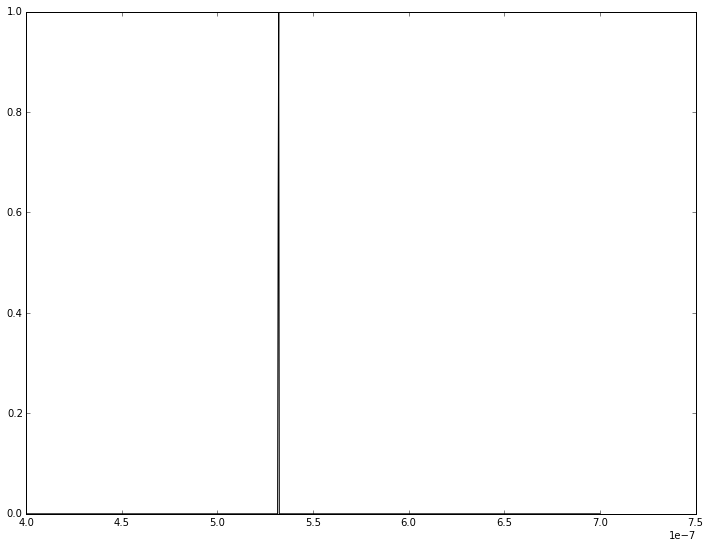

In [15]:
fig, ax=plt.subplots(figsize=(12,9))
ax.plot(l, skw, color='black')
#ax.set_xlim(-10,10)

In [34]:
'a' is ('string' or 'notstring')

False

In [22]:
%timeit RWandIW(l)

The slowest run took 17.15 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 3.9 µs per loop


In [140]:
w=scipy.special.wofz
a,b=1,2
w(1)

(0.36787944117144233+0.60715770584139372j)

In [24]:
print(scipy.special.erfcx(-0.4j),w(0.4))

(0.852143788966+0.406152726347j) (0.852143788966+0.406152726347j)


In [3]:
a=2

In [34]:
chi_w(1)

(-0.076159013825536803+0.6520493321732922j)

In [9]:
k.mean()

9039377.464769803

In [39]:
np.real(chi_w(x))

array([  1.00000000e+00,   9.99967936e-01,   9.99871749e-01,
         9.99711451e-01,   9.99487062e-01,   9.99198612e-01,
         9.98846137e-01,   9.98429682e-01,   9.97949301e-01,
         9.97405056e-01,   9.96797015e-01,   9.96125258e-01,
         9.95389870e-01,   9.94590945e-01,   9.93728586e-01,
         9.92802903e-01,   9.91814014e-01,   9.90762046e-01,
         9.89647134e-01,   9.88469419e-01,   9.87229053e-01,
         9.85926195e-01,   9.84561009e-01,   9.83133671e-01,
         9.81644362e-01,   9.80093273e-01,   9.78480601e-01,
         9.76806551e-01,   9.75071337e-01,   9.73275180e-01,
         9.71418307e-01,   9.69500954e-01,   9.67523366e-01,
         9.65485793e-01,   9.63388493e-01,   9.61231732e-01,
         9.59015784e-01,   9.56740928e-01,   9.54407452e-01,
         9.52015651e-01,   9.49565827e-01,   9.47058289e-01,
         9.44493353e-01,   9.41871341e-01,   9.39192584e-01,
         9.36457417e-01,   9.33666185e-01,   9.30819237e-01,
         9.27916930e-01,

In [10]:
cd "~"

C:\Users\jdavies


In [11]:
cd "Downloads/"

C:\Users\jdavies\Downloads


In [14]:
np.genfromtxt('zb_Spk_C_NLTE.txt', delimiter='       ', skip_header=4)

array([[  1.00000000e-01,   9.99999991e-38,   1.00000006e-20],
       [  1.00100000e-01,   9.99999991e-38,   1.00000006e-20],
       [  1.00200000e-01,   9.99999991e-38,   1.00000006e-20],
       ..., 
       [  9.00710000e+03,   5.99993868e+00,   5.99993911e+17],
       [  9.00810000e+03,   5.99993869e+00,   5.99993912e+17],
       [  9.00910000e+03,   5.99993870e+00,   5.99993913e+17]])